In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

with base_campanhas as (
select * from (
select 
activityname --jornada campanha
, journeyname --campanha
, subject
, id_customer
, sum(nr_click) as cliques
, sum(nr_open) as aberturas
, min(dt_envio) as dt_envio
from 
martech_curated_zone.retorno_email_sfmc
where eventtype = 'Sent'
and tipo <> 'Transacional'
group by 1,2,3,4
union all 
select 
communication_name as activityname --jornada campanha
, communication_name as journeyname --campanha
, subject
, cl.id_customer
, sum(clicks) as cliques
, sum(opens) as aberturas
, min(send_at) as dt_envio
from 
martech_curated_zone.log_infobip_email_pag p
inner join growth_curated_zone.clientes cl on (cl.email = p."to")
where status = 'Delivered'
group by 1,2,3,4
)
where lower(journeyname) not like '%%cobranca%%'
and lower(journeyname) not like '%%cobrança%%'
and lower(journeyname) not like '%%aquisicao%%'
and lower(journeyname) not like '%%aquisição%%'
and lower(subject) not like '%%willclipping%%' 
and lower(subject) not like '%%relatório%%'
and lower(subject) not like '%%boletim%%'
and lower(subject) not like '%%correios%%'
and lower(subject) not like '%%newsletter%%'
and lower(journeyname) not like '%%teste%%'
and lower(subject) not like '%%teste%%'
and lower(journeyname) not like '%%pesquisa%%'
and lower(journeyname) not like '%%comunicação interna%%'
and lower(journeyname) not like '%%café%%'
and lower(journeyname) not like '%%cxm%%'
and lower(journeyname) not like '%%acesso%%'
and lower(subject) not like '%%[will bank e pag%%'
and lower(subject) not like '%%[willbank]%%'
and lower(subject) not like '%%[meu pag]%%'
and lower(subject) not like '%%[meupag]%%'
and lower(subject) not like '%%[will bank]%%'
and lower(subject) not like '%%pag amarelo%%'
and lower(journeyname) not like '%%unresolved communication%%'
and lower(subject) not like '%%certificado%%'
and lower(journeyname) not like '%%ri_pessoas%%'
and lower(subject) not like '%%will em um minuto%%'
and lower(subject) not like '%%chegaram os vouchers%%'
and dt_envio >= to_date('2023-01-01','yyyy-mm-dd')
)
, conversao_cartao as (
select distinct id_cliente,  dt_data
from platform_curated_zone.transaction_dedicada_spending 
where dt_data >= to_date('2023-01-01','yyyy-mm-dd')
)
, flags_principais as (
select
coalesce(b.id_customer, ct.id_cliente) as id_customer,
date_trunc('month', coalesce(c.dt_envio, ct.dt_data)) as mes_ref,
case when c.id_customer is null then 0 else 1 end as f_tratamento,
case when ct.id_cliente is null then 0 else 1 end as f_conversao,
case when c.aberturas > 0 then 1 else 0 end as f_comunicacao
from customer_analytics_zone.ca_analitico_basao_crm b 
left join base_campanhas c on (c.id_customer = b.id_customer)
full outer join conversao_cartao ct on (ct.id_cliente = c.id_customer and date_diff('day', c.dt_envio, ct.dt_data) <= 7 and date_diff('day', c.dt_envio, ct.dt_data) > 0 )
)
, com_aleatorizacao as (
select 
*, row_number() over (partition by f_tratamento, f_conversao, f_comunicacao order by rand()) as ordem
from flags_principais
)
select 
b.id_customer
, b.f_tratamento, b.f_conversao, b.f_comunicacao
, c.pc_iu_ult_mes
, c.pc_iu_mes_atual
, c.vl_spending_medio_3m
, c.ds_classif_application
, c.ds_classif_behavior
, c.ds_classif_compra_online
, c.nr_score_ie_credito
, c.nr_score_ie_conta
, c.ds_rfe_credito
, c.ds_persona
, c.ds_perfil_research
, c.ds_seg_consumo
from 
com_aleatorizacao b
left join customer_analytics_zone.ca_analitico_basao_crm c on (c.id_customer = b.id_customer)
where ordem <= 100000


"""

df = ac.df_athena('flavia-costa', query)

In [3]:
len(df)

600000

In [4]:
df.dtypes

id_customer                  object
f_tratamento                  int64
f_conversao                   int64
f_comunicacao                 int64
pc_iu_ult_mes               float64
pc_iu_mes_atual             float64
vl_spending_medio_3m        float64
ds_classif_application       object
ds_classif_behavior          object
ds_classif_compra_online     object
nr_score_ie_credito         float64
nr_score_ie_conta           float64
ds_rfe_credito               object
ds_persona                   object
ds_perfil_research           object
ds_seg_consumo               object
dtype: object

In [5]:
df.head()

,id_customer,f_tratamento,f_conversao,f_comunicacao,pc_iu_ult_mes,pc_iu_mes_atual,vl_spending_medio_3m,ds_classif_application,ds_classif_behavior,ds_classif_compra_online,nr_score_ie_credito,nr_score_ie_conta,ds_rfe_credito,ds_persona,ds_perfil_research,ds_seg_consumo
0,3859089,0,0,0,NaN,NaN,NaN,9,4,None,0.000000,NaN,None,"16 - Homem, 25 a 40 anos, Nordeste",Acumulador,None
1,3767854,0,0,0,NaN,NaN,NaN,8,2,None,0.000000,NaN,None,"22 - Mulher, Até 24 anos, Nordeste",BP - Multiplicador / Acumulador,None
2,3134318,0,0,0,NaN,NaN,NaN,None,None,None,0.000000,NaN,None,"16 - Homem, 25 a 40 anos, Nordeste",None,None
3,92065dc6-db47-4e1c-8fe0-ff864f3c9ef7,0,0,0,0.9235,0.3246,71.0,11,None,None,32.653061,NaN,02-Cliente novo - onliner,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",Multiplicador,None
4,067a68fd-d589-41c3-bc30-c62d0a19f433,0,0,0,0.9998,NaN,127.0,15,None,None,NaN,49.74,02-Cliente novo - onliner,"3 - Mulher, Solteira, 35 anos ou mais, cidade ...",None,None


In [6]:
df.isnull().sum()

id_customer                     22
f_tratamento                     0
f_conversao                      0
f_comunicacao                    0
pc_iu_ult_mes               115337
pc_iu_mes_atual             324091
vl_spending_medio_3m        113287
ds_classif_application       60684
ds_classif_behavior          81950
ds_classif_compra_online    216040
nr_score_ie_credito          55364
nr_score_ie_conta           171565
ds_rfe_credito               85973
ds_persona                    8329
ds_perfil_research           54856
ds_seg_consumo              321950
dtype: int64

In [7]:
id_columns = ['id_customer']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [8]:
df.drop(id_columns, axis=1).describe()

,f_tratamento,f_conversao,f_comunicacao,pc_iu_ult_mes,pc_iu_mes_atual,vl_spending_medio_3m,nr_score_ie_credito,nr_score_ie_conta
count,600000.000000,600000.0,600000.000000,484663.000000,275909.000000,486713.0,544636.000000,428435.000000
mean,0.666667,0.5,0.333333,0.858852,0.778679,inf,48.492356,52.840169
std,0.471405,0.5,0.471405,1.386086,0.383555,NaN,29.165832,23.164712
min,0.000000,0.0,0.000000,-1.006500,-1.000000,-2389.0,0.000000,7.410000
25%,0.000000,0.0,0.000000,0.690000,0.530500,311.0,27.118644,35.060000
50%,1.000000,0.5,0.000000,0.974200,0.890000,625.0,55.932203,53.050000
75%,1.000000,1.0,1.000000,1.000000,1.000000,1224.0,72.881356,71.440000
max,1.000000,1.0,1.000000,656.212900,22.840000,inf,100.000000,99.910000


In [9]:
df['f_conversao'].value_counts()

0    300000
1    300000
Name: f_conversao, dtype: int64

In [10]:
pd.crosstab(df.f_conversao, df.f_tratamento)

f_tratamento,0,1
f_conversao,,
0,100000,200000
1,100000,200000


In [13]:
df['f_uplift'] = np.where((df['f_tratamento'] == 1) & (df['f_conversao'] == 1), 1, 0)

In [12]:
df['f_uplift'].value_counts(normalize=True)

0    0.666667
1    0.333333
Name: f_uplift, dtype: float64

In [14]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [15]:
df.isnull().sum()

id_customer                 0
f_tratamento                0
f_conversao                 0
f_comunicacao               0
pc_iu_ult_mes               0
pc_iu_mes_atual             0
vl_spending_medio_3m        0
ds_classif_application      0
ds_classif_behavior         0
ds_classif_compra_online    0
nr_score_ie_credito         0
nr_score_ie_conta           0
ds_rfe_credito              0
ds_persona                  0
ds_perfil_research          0
ds_seg_consumo              0
f_uplift                    0
dtype: int64

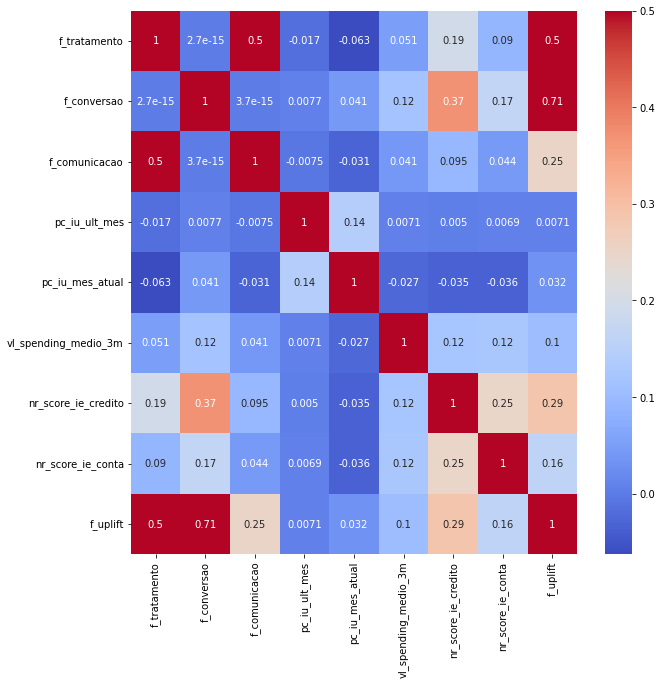

In [16]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
df_model = pd.get_dummies(df, columns=cat_columns)

In [19]:
nao_preditor = ['id_customer', 'f_conversao', 'f_uplift', 'f_comunicacao']
target = ['f_conversao']

preditores = df_model.drop(nao_preditor, axis = 1).columns

In [20]:
df_model.isnull().sum()

id_customer                  0
f_tratamento                 0
f_conversao                  0
f_comunicacao                0
pc_iu_ult_mes                0
                            ..
ds_seg_consumo_VIAGEM - 2    0
ds_seg_consumo_VIAGEM - 3    0
ds_seg_consumo_VIAGEM - 4    0
ds_seg_consumo_VIAGEM - 5    0
ds_seg_consumo_VIAGEM - 6    0
Length: 218, dtype: int64

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier


In [22]:
x_train, x_test, y_train, y_test = train_test_split(df_model[preditores]
                                                    , df_model[target]
                                                    , random_state=42, test_size=0.20)

In [23]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [1]:
x_test.head()

NameError: name 'x_test' is not defined

In [25]:
x_test_sim = x_test

x_test_sim['f_tratamento'] = 0

In [35]:
svm_clf = svm.SVC()
svm_clf.fit(x_train, y_train)


/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_predicted_clf = svm_clf.predict(x_test)
print(metrics.accuracy_score(y_test, y_predicted_clf).round(4))

In [ ]:
y_predicted_clf_sim = svm_clf.predict(x_test_sim)

In [ ]:
df_analise = x_test
len(df_analise)

In [ ]:
df_analise['prediction_actual'] = y_predicted_clf
df_analise['prediction_sim'] = y_predicted_clf_sim

In [ ]:
df_analise['ate'] = df_analise['prediction_actual'] - df_analise['prediction_sim']

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise, x = 'ate', color = "black")

In [ ]:
df_analise['ate'].describe()

In [ ]:
#import funcionalidade as fc

#df_analise['cont'] = 1

In [ ]:
""" def discretiza(df, drop_col):
    num_columns = df.drop(drop_col, axis = 1).select_dtypes(exclude=['object']).columns
    stats = df.drop(drop_col, axis=1).describe()
    for i in num_columns:
        p75 = stats.iloc[6][i]
        p25 = stats.iloc[4][i]
        p50 = stats.iloc[5][i]
        
        df['aux'] = np.where((df[i] <= p25), "A - " + i,
                    np.where((df[i] > p25) & (df[i] <= p50), "B - " + i,
                    np.where((df[i] > p50) & (df[i] <= p75), "C - " + i, "D - " + i)))
  
        df = df.rename(columns = {'aux':i+"_fx"})

    return df """